In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. 데이터 불러오기

* 데이터는 한 시간 간격으로 기록
* 기상 데이터 - 2015-01-01 ~ 2021-04-30 당진 기상관측데이터, 울산 기상관측데이터
* 발전량 데이터 - 2015-01-01 ~ 2021-01-31 수상, 자재창고, 당진, 울산 4개 장소
                                          (ulsan_not_used 열은 삭제하고 진행)

In [6]:
#당진, 울산 기상 관측 데이터
raw_weather_dangjin = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/dangjin_obs_15_21.csv')
raw_weather_ulsan = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/ulsan_obs_15_21.csv')

# floating, warehouse, dangjin, ulsan 발전량 데이터
raw_power_dataset = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/energy_new.csv') 

#### 1.1 기상데이터

In [7]:
print(raw_weather_dangjin.shape, raw_weather_ulsan.shape)
raw_weather_dangjin.tail()

(55488, 8) (55488, 8)


,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud
55483,2021-04-30 19:00,0.11,30.555558,10.1,84.0,-2.300000e+00,-5.630000e-16,4.0
55484,2021-04-30 20:00,0.00,0.000000,9.7,82.0,-1.221600e+00,4.446262e-01,4.0
55485,2021-04-30 21:00,NaN,0.000000,9.3,86.0,-3.078181e-01,-8.457234e-01,4.0
55486,2021-04-30 22:00,NaN,0.000000,9.1,90.0,6.120000e-18,1.000000e-01,4.0
55487,2021-04-30 23:00,NaN,0.000000,8.8,93.0,-3.213938e-01,3.830222e-01,4.0


* cos(time) 변수 추가 및 null값이 있는 ghi 열 삭제

In [8]:
cos_time = []
for i in range(raw_weather_dangjin['Time'].shape[0]):
     cos_time.append(np.cos(2*np.pi/24*int(raw_weather_dangjin['Time'][i][-5:-3])))
cos_weather_dangjin = pd.concat([raw_weather_dangjin,pd.DataFrame(cos_time)],axis=1)
cos_weather_ulsan = pd.concat([raw_weather_ulsan,pd.DataFrame(cos_time)],axis=1)
cos_weather_dangjin.rename(columns = {0:'cos(time)'}, inplace=True)
cos_weather_ulsan.rename(columns = {0:'cos(time)'}, inplace=True)

In [9]:
cos_weather_dangjin.head()

,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,cos(time)
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-1.812707,4.980371,3.0,1.000000
1,2015-01-01 1:00,NaN,0.0,-4.4,47.0,-1.846909,5.074340,3.0,0.965926
2,2015-01-01 2:00,NaN,0.0,-4.6,50.0,-1.675899,4.604494,3.0,0.866025
3,2015-01-01 3:00,NaN,0.0,-4.7,50.0,-3.985283,4.749476,3.0,0.707107
4,2015-01-01 4:00,NaN,0.0,-5.0,56.0,-3.213938,3.830222,3.0,0.500000


In [10]:
cos_weather_ulsan.head()

,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,cos(time)
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-6.108002,2.223131e+00,1,1.000000
1,2015-01-01 1:00,NaN,0.0,-1.0,42.0,-4.500000,-1.100000e-15,1,0.965926
2,2015-01-01 2:00,NaN,0.0,-1.3,39.0,-2.185478,2.604551e+00,1,0.866025
3,2015-01-01 3:00,NaN,0.0,-2.5,49.0,-3.213938,3.830222e+00,1,0.707107
4,2015-01-01 4:00,NaN,0.0,-3.3,36.0,-5.826094,2.120525e+00,1,0.500000


In [11]:
weather_dangjin = cos_weather_dangjin[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]
weather_ulsan = cos_weather_ulsan[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]

#### 1.2 발전량 데이터

In [12]:
power_dataset = raw_power_dataset[:]
power_dataset.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan_not_used,ulsan
0,2015-01-01 1:00,0.0,0.0,0.0,NaN,NaN
1,2015-01-01 2:00,0.0,0.0,0.0,NaN,NaN
2,2015-01-01 3:00,0.0,0.0,0.0,NaN,NaN
3,2015-01-01 4:00,0.0,0.0,0.0,NaN,NaN
4,2015-01-01 5:00,0.0,0.0,0.0,NaN,NaN


* 데이터 분포 시각화
* null 값이 드문드문 보임
* 당진, 울산 일사량 분포 이상 -> 당진은 구간을 나눠 MinMax 진행, 울산은 별다른 조치 x

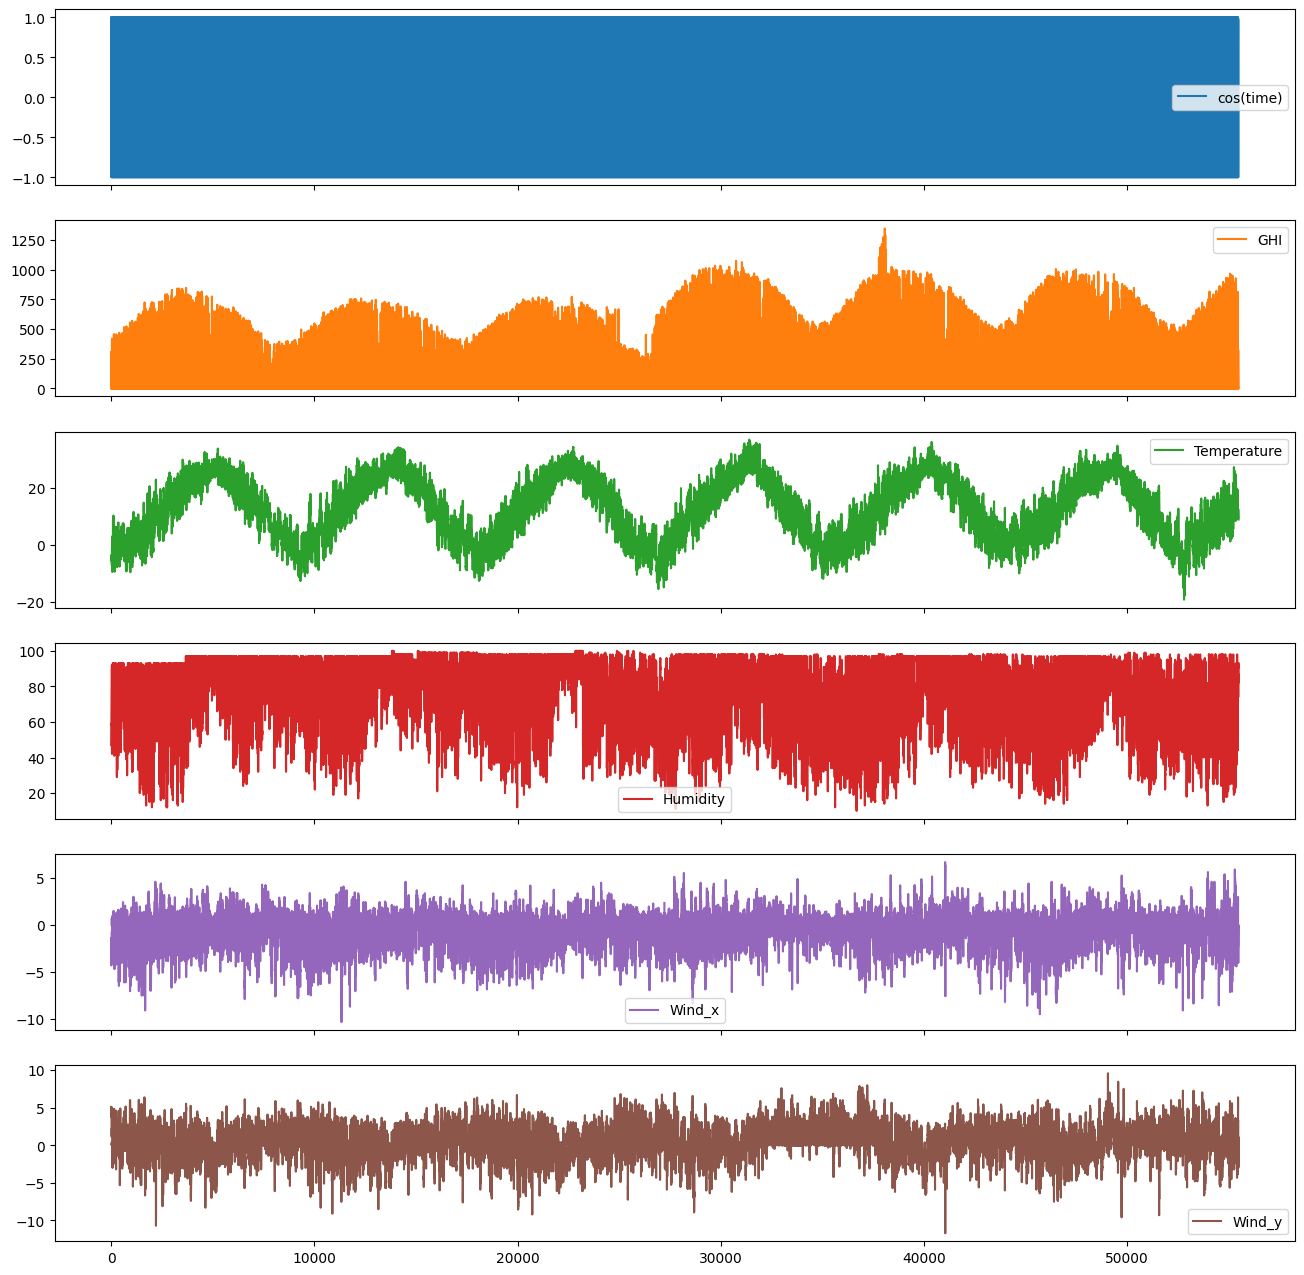

In [13]:
plt.style.use("default")
weather_dangjin.plot(subplots=True, figsize=(16, 16));

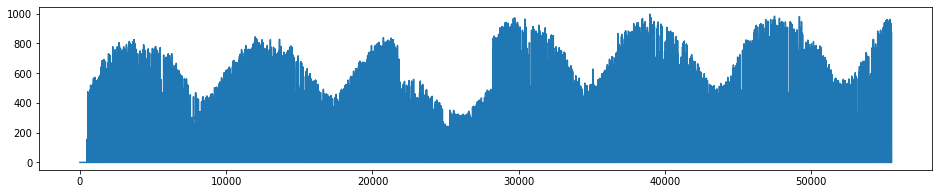

In [14]:
weather_ulsan['GHI'].plot(figsize=(16,3));

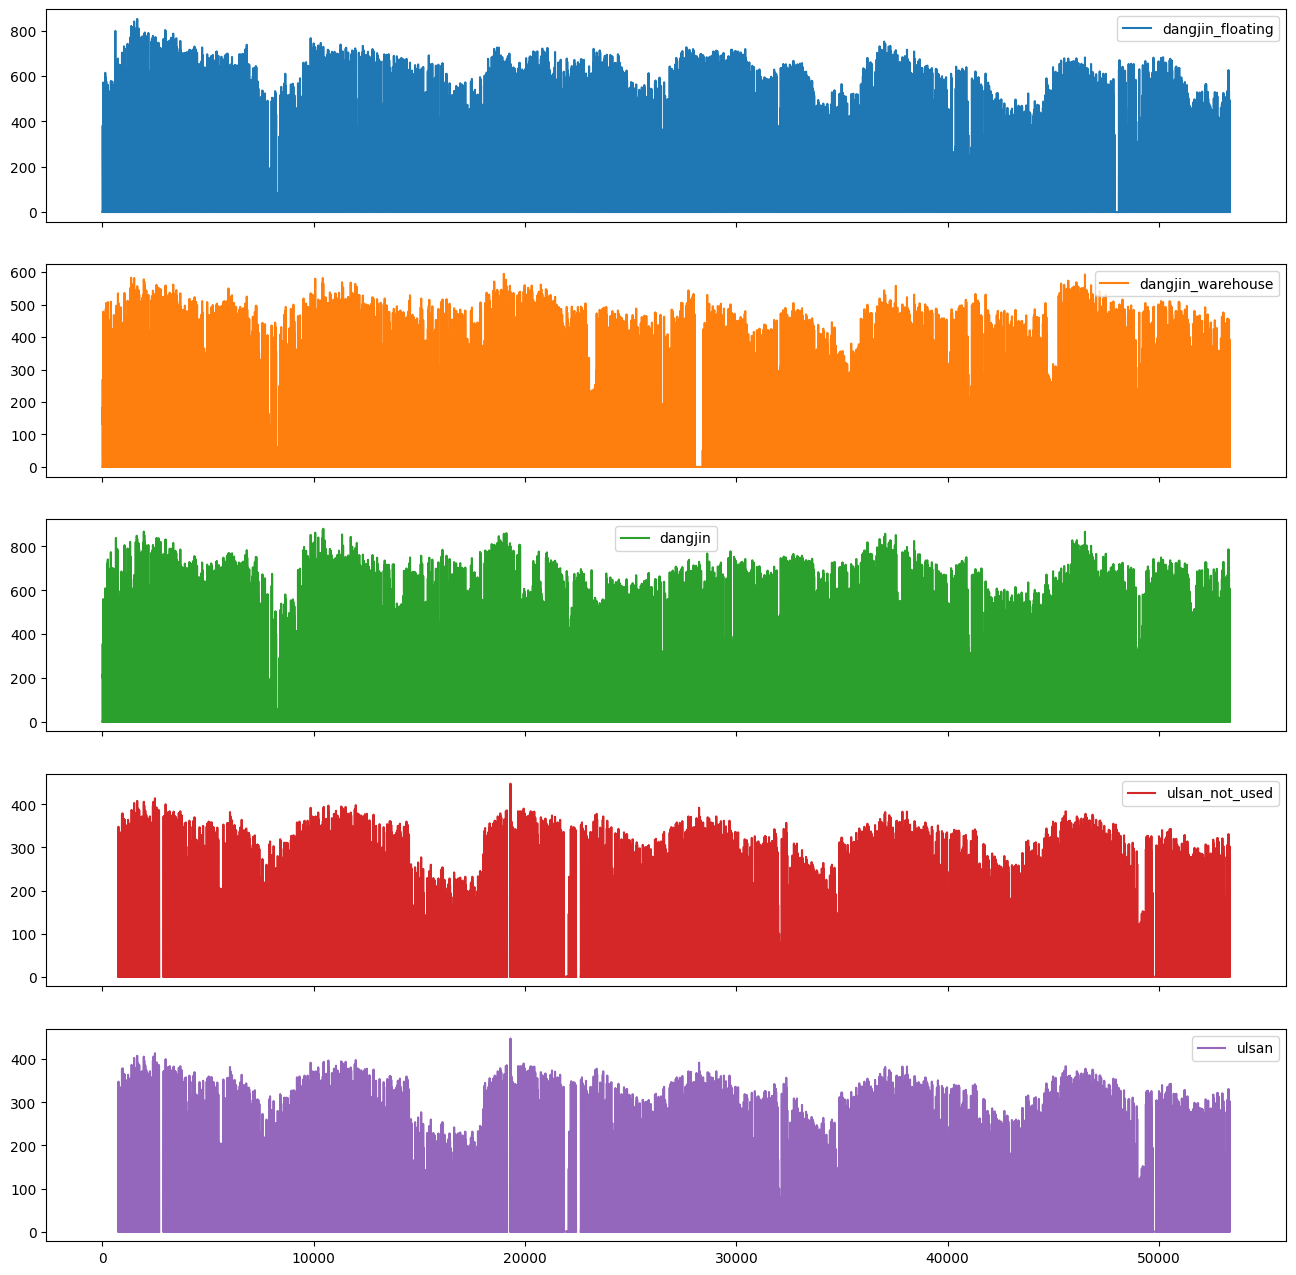

In [16]:
power_dataset.plot(subplots=True, figsize=(16,16));

* 이상치 제거 및 결측치 채워넣기

In [17]:
#1000이상인 일사량을 이상치로 보고 null로 대체
for i in range(len(weather_dangjin)):
    if weather_dangjin['GHI'][i] > 1000:
        weather_dangjin['GHI'][i] = np.nan;

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
power_dataset = power_dataset.drop(['ulsan_not_used','time'], axis=1)

In [19]:
# null 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(weather_dangjin.values)
imp_weather_dangjin = imputer.transform(weather_dangjin.values)

imputer.fit(weather_ulsan.values)
imp_weather_ulsan = imputer.transform(weather_ulsan.values)

imputer.fit(power_dataset.values)
proc_power_dataset = imputer.transform(power_dataset.values)

print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_dangjin).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_ulsan).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(proc_power_dataset).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0


In [20]:
bound_for_scaler = np.where(raw_weather_dangjin['Time']=='2018-01-01 0:00')[0][0]

In [21]:
imp_weather_dangjin_1 = imp_weather_dangjin[bound_for_scaler:]
imp_weather_dangjin_2 = imp_weather_dangjin[:bound_for_scaler]

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scipy as sp
import scipy.stats
scaler = MinMaxScaler()
scaler.fit(imp_weather_dangjin_1)
imp_weather_dangjin_1_scaled = scaler.transform(imp_weather_dangjin_1)
# 당진만 2개로 쪼개서 각각 스케일링
scaler.fit(imp_weather_dangjin_2)
imp_weather_dangjin_2_scaled = scaler.transform(imp_weather_dangjin_2)

scaler.fit(imp_weather_ulsan)
imp_weather_ulsan_scaled = scaler.transform(imp_weather_ulsan)

imp_weather_dangjin_scaled = pd.concat([pd.DataFrame(imp_weather_dangjin_2_scaled),
                                        pd.DataFrame(imp_weather_dangjin_1_scaled)], axis =0)

proc_weather_dangjin = pd.DataFrame(data = np.array(imp_weather_dangjin_scaled),
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])
proc_weather_ulsan = pd.DataFrame(data=imp_weather_ulsan_scaled, 
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])


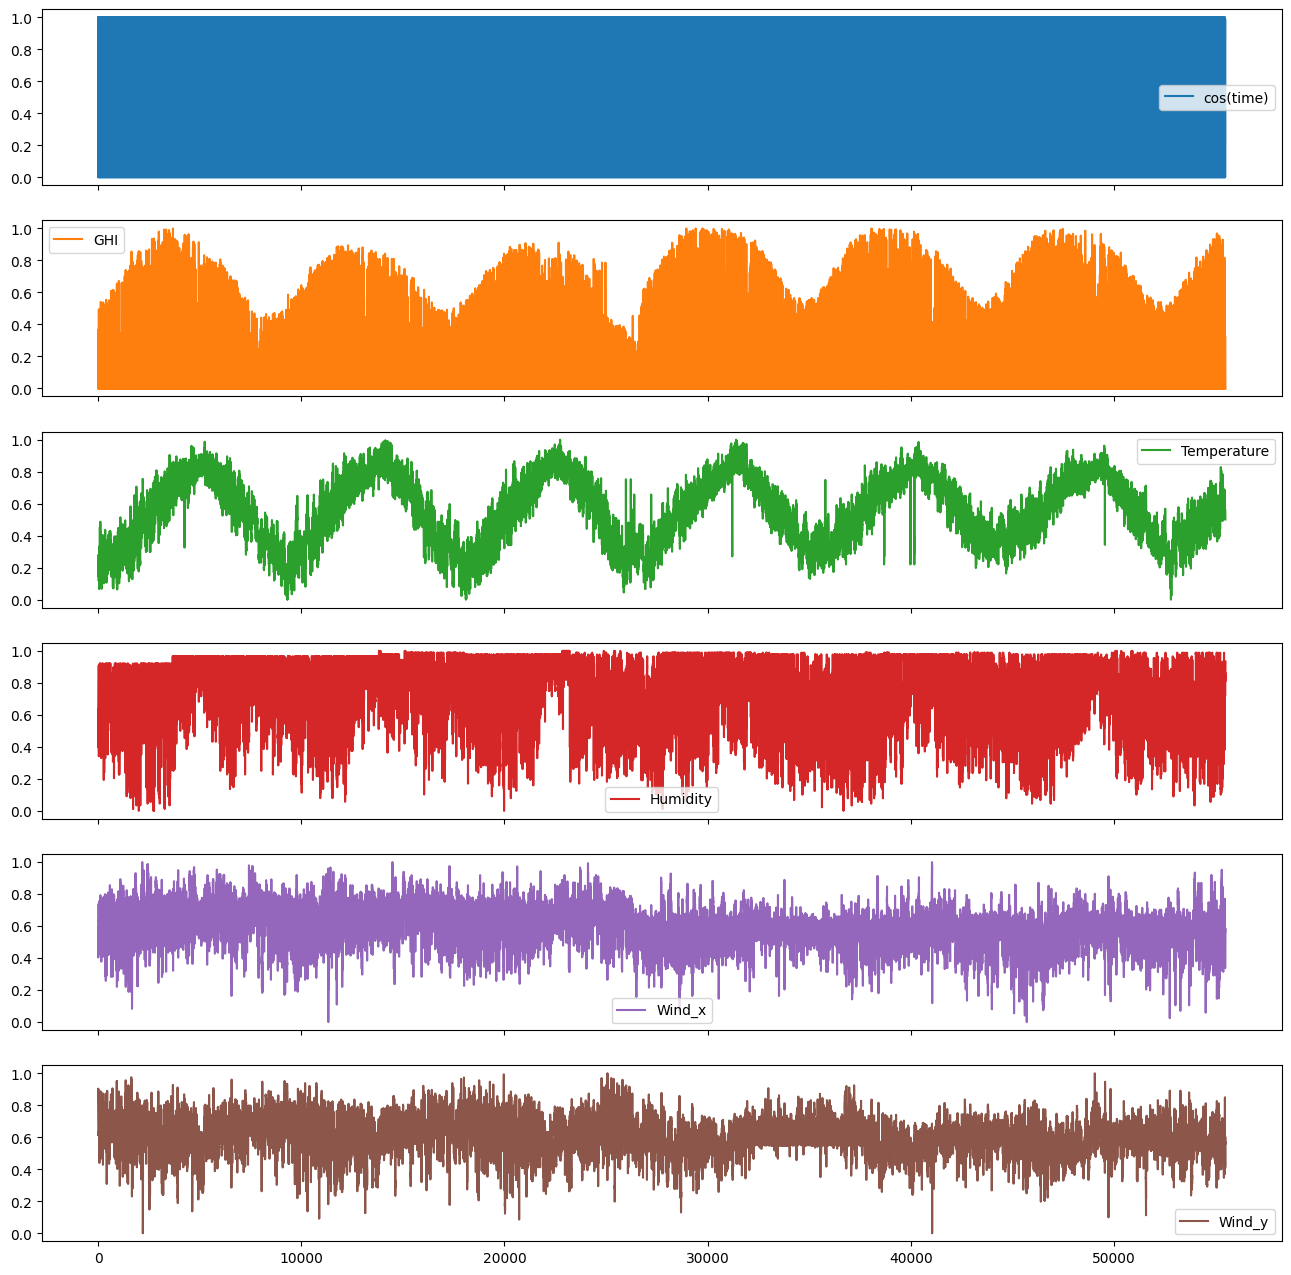

In [25]:
plt.style.use("default")
proc_weather_dangjin.plot(subplots=True, figsize=(16,16));

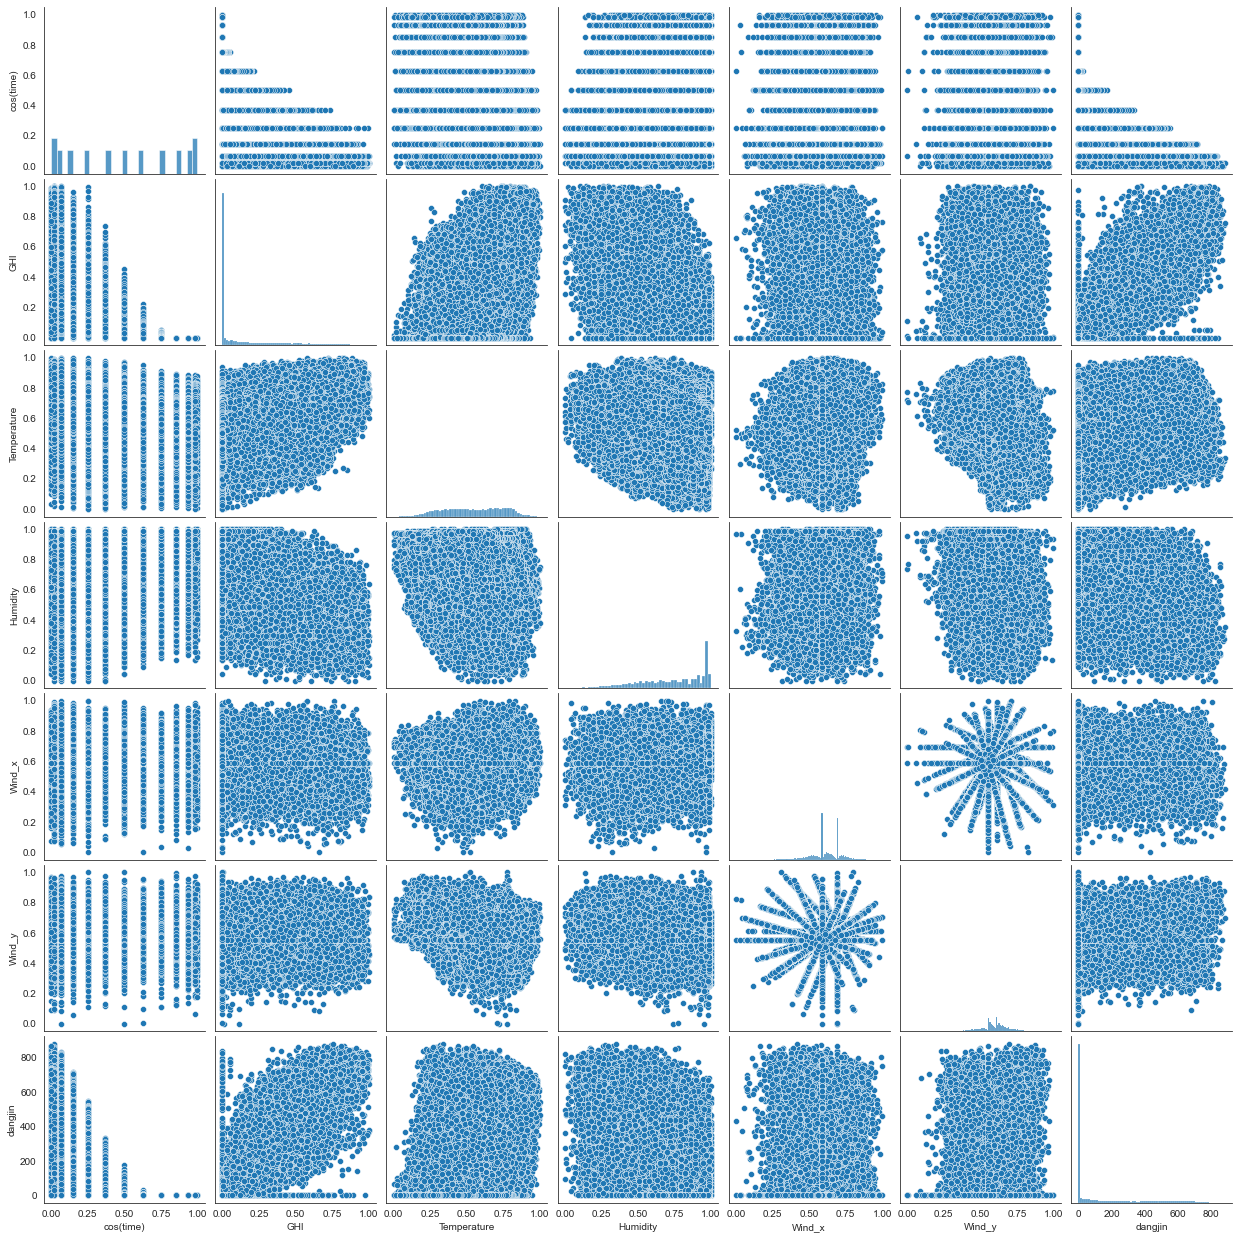

In [28]:
import seaborn as sns
sns.set_style("white")
sns.pairplot(pd.concat([proc_weather_dangjin[['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y']], proc_power_dataset['dangjin']],
                                          axis=1))


In [38]:
proc_power_dataset = pd.DataFrame(power_dataset)

In [39]:
temp_dataset_dangjin = pd.concat([proc_weather_dangjin,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset.drop('ulsan', axis=1)],axis=1)
temp_dataset_ulsan = pd.concat([proc_weather_ulsan,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset['ulsan']],axis=1)

imputer.fit(temp_dataset_dangjin.values)
final_dataset_dangjin = imputer.transform(temp_dataset_dangjin.values)

imputer.fit(temp_dataset_ulsan.values)
final_dataset_ulsan = imputer.transform(temp_dataset_ulsan.values)

In [40]:
final_dataset_dangjin = pd.DataFrame(final_dataset_dangjin, columns = temp_dataset_dangjin.columns)
final_dataset_ulsan = pd.DataFrame(final_dataset_ulsan, columns = temp_dataset_ulsan.columns)

In [41]:
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(np.array(final_dataset_ulsan)).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0


## 2. 모델링 및 학습

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,20))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,150])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,80])
    plt.legend()
    plt.show()

In [44]:
from keras import layers
def build_model(x_train):
    model = keras.Sequential([
                            layers.Dense(256, activation='relu', input_shape=[len(x_train.keys())]),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae','mse'])
    return model

In [45]:
# 이 셀은 cloud 별로 나누려다 실패한 셀.... 재코딩 필요! 
def train_each_cloud(final_dataset_dangjin, final_dataset_ulsan, region):
    dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
    dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
    dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]
    
    ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
    ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
    ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]
    
    power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
    power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
    power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    if region == 'dangjin':
        train_dataset = final_dataset_dangjin[dangjin_start:dangjin_bound]
        test_dataset = final_dataset_dangjin[dangjin_bound:dangjin_end]
        for cloud_idx in [1,2,3,4]:
            cloud = train_dataset['Cloud'][train_dataset['Cloud']==cloud_idx].index
            cloud_train_dataset = pd.DataFrame()
            for i in cloud:
                cloud_train_dataset = pd.concat([cloud_train_dataset,train_dataset[i:i+1]], axis = 0)                              
                print(pd.DataFrame(cloud_train_dataset))
                for place in ['dangjin', 'dangjin_warehouse', 'dangjin_floating']:
                    x_train, x_test, y_train, y_test = train_test_split(cloud_train_dataset[['cos(time)',
                                                                                             'GHI',
                                                                                             'Temperature',
                                                                                             'Humidity',
                                                                                             'Wind_x',
                                                                                             'Wind_y']], 
                                                                        cloud_train_dataset[place],
                                                                        test_size=0.2, shuffle=False)
                    EPOCHS = 200
                    model = build_model(x_train)
                    history = model.fit(x_train, y_train, epochs=EPOCHS,
                                        batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])
                    plot_history(history)
                    loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
                    print("%s test set의 MAE: %.3f"%(place,mae1))

                    answer_df = test_dataset[place][np.where(test_dataset)]
                    test_period = test_dataset[['cos(time)',
                                                 'GHI',
                                                 'Temperature',
                                                 'Humidity',
                                                 'Wind_x',
                                                 'Wind_y']]
                    submission_df = np.squeeze(model_dangjin.predict(test_period))
                    
                    print("NMAE for MLP :",sola_nmae(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

        

In [93]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 3200
    target_idx = pd.DataFrame(sum_answer[sum_answer>=3200*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [95]:
def train(final_dataset_dangjin, final_dataset_ulsan, region):
    model_list = []
    dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
    dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
    dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]
    
    ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
    ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
    ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]
    
    power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
    power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
    power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    if region == 'dangjin':
        train_dataset = final_dataset_dangjin[dangjin_start:dangjin_bound]
        test_dataset = final_dataset_dangjin[dangjin_bound:dangjin_end]

        for place in ['dangjin', 'dangjin_warehouse', 'dangjin_floating']:
            x_train, x_test, y_train, y_test = train_test_split(train_dataset[['cos(time)',
                                                                                     'GHI',
                                                                                     'Temperature',
                                                                                     'Humidity',
                                                                                     'Wind_x',
                                                                                     'Wind_y']], 
                                                                train_dataset[place],
                                                                test_size=0.2, shuffle=True)
            EPOCHS = 200
            model = build_model(x_train)
            history = model.fit(x_train, y_train, epochs=EPOCHS,
                                batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])
            
            plot_history(history)
            loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
            print("%s test set의 MAE: %.3f"%(place,mae1))
            globals()['model_{}'.format(place)] = model
            globals()['history_{}'.format(place)] = history
    
        return (model_dangjin, model_dangjin_warehouse, model_dangjin_floating, 
                history_dangjin, history_dangjin_warehouse, history_dangjin_floating)
    
    if region =='ulsan':
        train_dataset = final_dataset_ulsan[ulsan_start:ulsan_bound]
        test_dataset = final_dataset_ulsan[ulsan_bound:ulsan_end]

        for place in ['ulsan']:
            x_train, x_test, y_train, y_test = train_test_split(train_dataset[['cos(time)',
                                                                         'GHI',
                                                                         'Temperature',
                                                                         'Humidity',
                                                                         'Wind_x',
                                                                         'Wind_y']], 
                                                    train_dataset[place],
                                                    test_size=0.2, shuffle=True)
            EPOCHS = 200
            model = build_model(x_train)
            history = model.fit(x_train, y_train, epochs=EPOCHS,
                    batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])

            plot_history(history)
            loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
            print("%s test set의 MAE: %.3f"%(place,mae1))
        
        return model, history
            

* train(당진 기상+발전량 병합데이터, 울산 기상+발전량 병합데이터, '지역명')
* 당진을 고르면 3군데 각각 model과 history를 반환한다.
* 울산을 고르면 1군데 model과 history 반환

Epoch 1/200
216/216 - 1s - loss: 73.9718 - mae: 73.9718 - mse: 23723.4121 - val_loss: 39.4102 - val_mae: 39.4102 - val_mse: 6518.1401
Epoch 2/200
216/216 - 1s - loss: 51.9287 - mae: 51.9287 - mse: 10730.2188 - val_loss: 38.2581 - val_mae: 38.2581 - val_mse: 6284.3848
Epoch 3/200
216/216 - 0s - loss: 49.1731 - mae: 49.1731 - mse: 9859.9111 - val_loss: 40.7372 - val_mae: 40.7372 - val_mse: 7144.9648
Epoch 4/200
216/216 - 0s - loss: 47.7794 - mae: 47.7794 - mse: 9248.1064 - val_loss: 39.8840 - val_mae: 39.8840 - val_mse: 6419.2690
Epoch 5/200
216/216 - 1s - loss: 47.0433 - mae: 47.0433 - mse: 9024.2334 - val_loss: 38.1776 - val_mae: 38.1776 - val_mse: 6208.6470
Epoch 6/200
216/216 - 1s - loss: 47.4217 - mae: 47.4217 - mse: 9132.0635 - val_loss: 37.8493 - val_mae: 37.8493 - val_mse: 6120.4590
Epoch 7/200
216/216 - 1s - loss: 46.7422 - mae: 46.7422 - mse: 8794.9814 - val_loss: 37.7325 - val_mae: 37.7325 - val_mse: 5721.6821
Epoch 8/200
216/216 - 1s - loss: 45.3786 - mae: 45.3786 - mse: 8344

Epoch 63/200
216/216 - 0s - loss: 41.1845 - mae: 41.1845 - mse: 6995.6338 - val_loss: 36.9016 - val_mae: 36.9016 - val_mse: 5925.4507
Epoch 64/200
216/216 - 0s - loss: 41.4419 - mae: 41.4419 - mse: 7111.4565 - val_loss: 35.0157 - val_mae: 35.0157 - val_mse: 5363.5259
Epoch 65/200
216/216 - 0s - loss: 40.6731 - mae: 40.6731 - mse: 6954.0552 - val_loss: 35.1199 - val_mae: 35.1199 - val_mse: 5388.3428
Epoch 66/200
216/216 - 0s - loss: 40.8090 - mae: 40.8090 - mse: 6951.9956 - val_loss: 35.5399 - val_mae: 35.5399 - val_mse: 5414.3584
Epoch 67/200
216/216 - 0s - loss: 41.0707 - mae: 41.0707 - mse: 6989.0991 - val_loss: 36.4165 - val_mae: 36.4165 - val_mse: 5567.3506
Epoch 68/200
216/216 - 0s - loss: 41.5444 - mae: 41.5444 - mse: 7156.6416 - val_loss: 34.7119 - val_mae: 34.7119 - val_mse: 5451.8779
Epoch 69/200
216/216 - 0s - loss: 41.2326 - mae: 41.2326 - mse: 7148.5762 - val_loss: 35.0161 - val_mae: 35.0161 - val_mse: 5667.5596
Epoch 70/200
216/216 - 0s - loss: 40.7769 - mae: 40.7769 - mse

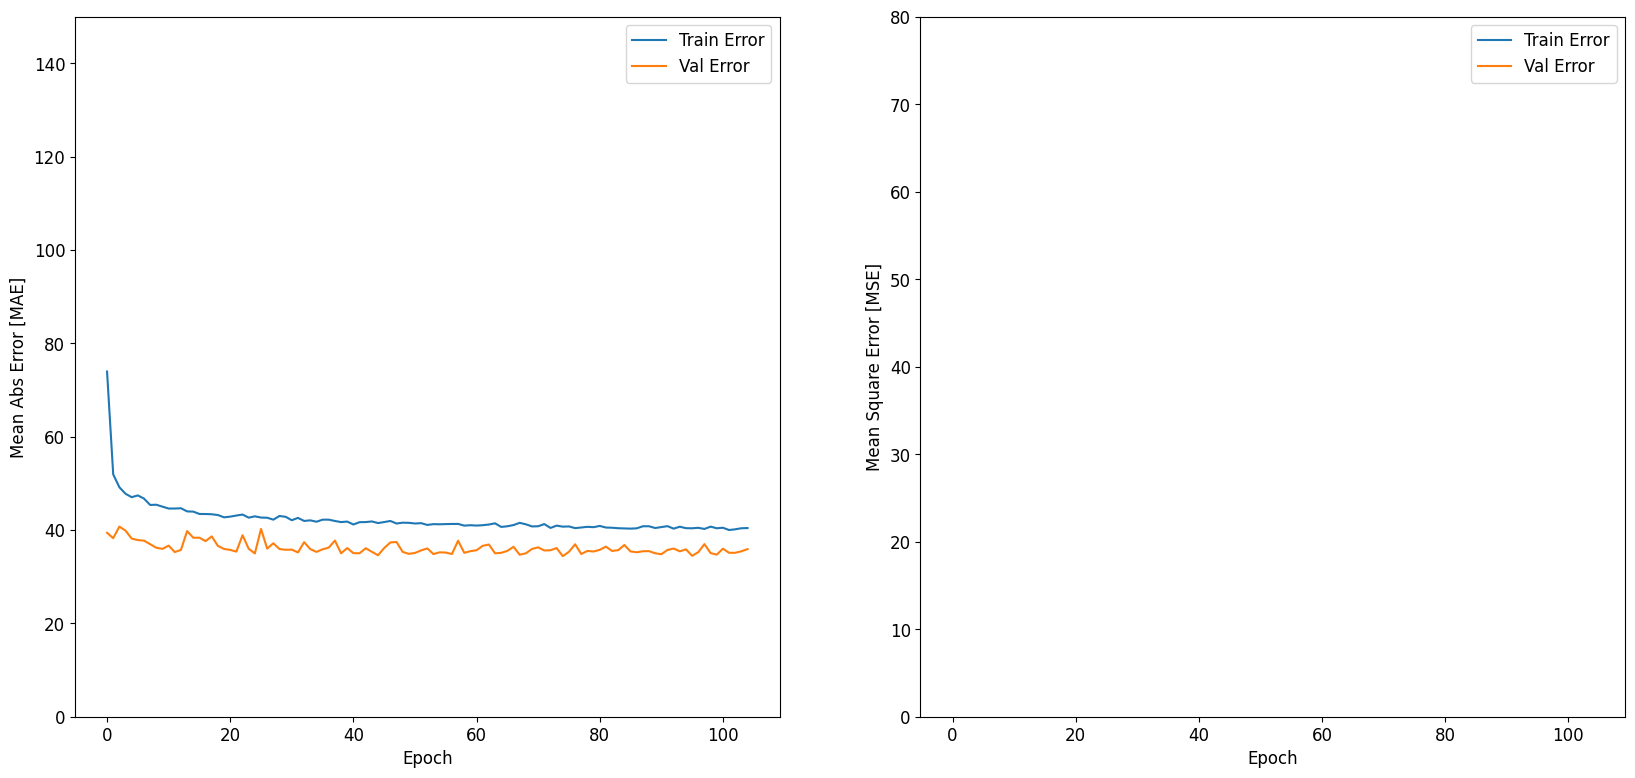

270/270 [==============================] - 0s 1ms/step - loss: 36.4619 - mae: 36.4619 - mse: 5520.9282
dangjin test set의 MAE: 36.462
Epoch 1/200
216/216 - 1s - loss: 44.5564 - mae: 44.5564 - mse: 8601.2227 - val_loss: 31.4341 - val_mae: 31.4341 - val_mse: 3804.1580
Epoch 2/200
216/216 - 1s - loss: 34.2229 - mae: 34.2229 - mse: 4793.0972 - val_loss: 25.5125 - val_mae: 25.5125 - val_mse: 3081.8264
Epoch 3/200
216/216 - 0s - loss: 33.6778 - mae: 33.6778 - mse: 4714.6929 - val_loss: 30.5444 - val_mae: 30.5444 - val_mse: 3681.9707
Epoch 4/200
216/216 - 1s - loss: 32.7609 - mae: 32.7609 - mse: 4499.3037 - val_loss: 29.9469 - val_mae: 29.9469 - val_mse: 3589.9575
Epoch 5/200
216/216 - 1s - loss: 31.7025 - mae: 31.7025 - mse: 4243.3608 - val_loss: 25.5053 - val_mae: 25.5053 - val_mse: 2921.9158
Epoch 6/200
216/216 - 0s - loss: 31.4515 - mae: 31.4515 - mse: 4168.6309 - val_loss: 26.4370 - val_mae: 26.4370 - val_mse: 2992.4192
Epoch 7/200
216/216 - 1s - loss: 31.0544 - mae: 31.0544 - mse: 4038.9

Epoch 60/200
216/216 - 0s - loss: 28.1467 - mae: 28.1467 - mse: 3464.8455 - val_loss: 24.6523 - val_mae: 24.6523 - val_mse: 2774.1885
Epoch 61/200
216/216 - 0s - loss: 28.2062 - mae: 28.2062 - mse: 3434.4011 - val_loss: 23.7938 - val_mae: 23.7938 - val_mse: 2694.3660
Epoch 62/200
216/216 - 0s - loss: 27.9729 - mae: 27.9729 - mse: 3402.0383 - val_loss: 23.5178 - val_mae: 23.5178 - val_mse: 2732.6262
Epoch 63/200
216/216 - 1s - loss: 28.0487 - mae: 28.0487 - mse: 3471.5044 - val_loss: 23.4424 - val_mae: 23.4424 - val_mse: 2692.0063
Epoch 64/200
216/216 - 0s - loss: 28.2624 - mae: 28.2624 - mse: 3536.2673 - val_loss: 24.0320 - val_mae: 24.0320 - val_mse: 2690.0481
Epoch 65/200
216/216 - 0s - loss: 28.0273 - mae: 28.0273 - mse: 3484.2163 - val_loss: 23.9187 - val_mae: 23.9187 - val_mse: 2696.0725
Epoch 66/200
216/216 - 0s - loss: 28.1128 - mae: 28.1128 - mse: 3482.2056 - val_loss: 24.3753 - val_mae: 24.3753 - val_mse: 2694.3875
Epoch 67/200
216/216 - 0s - loss: 28.2894 - mae: 28.2894 - mse

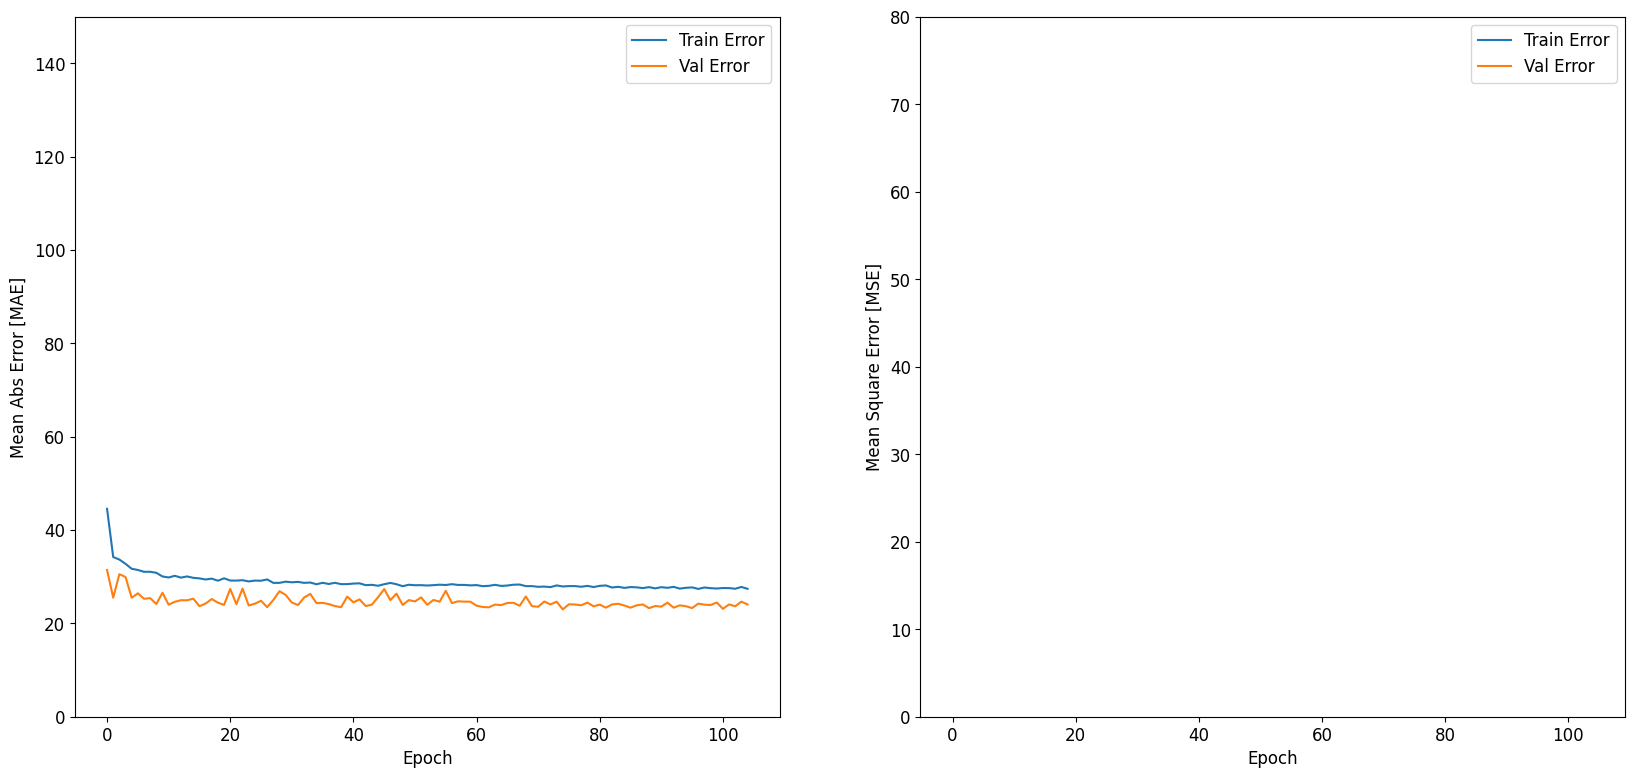

270/270 [==============================] - 0s 1ms/step - loss: 24.3705 - mae: 24.3705 - mse: 2654.2654
dangjin_warehouse test set의 MAE: 24.371
Epoch 1/200
216/216 - 1s - loss: 60.8125 - mae: 60.8125 - mse: 16212.6514 - val_loss: 36.4625 - val_mae: 36.4625 - val_mse: 5363.2217
Epoch 2/200
216/216 - 0s - loss: 45.7817 - mae: 45.7817 - mse: 8481.1191 - val_loss: 35.4836 - val_mae: 35.4836 - val_mse: 5078.6826
Epoch 3/200
216/216 - 0s - loss: 44.3170 - mae: 44.3170 - mse: 8083.6274 - val_loss: 38.2349 - val_mae: 38.2349 - val_mse: 5844.4956
Epoch 4/200
216/216 - 0s - loss: 43.1093 - mae: 43.1093 - mse: 7709.2959 - val_loss: 36.1448 - val_mae: 36.1448 - val_mse: 5182.7734
Epoch 5/200
216/216 - 0s - loss: 41.9391 - mae: 41.9391 - mse: 7261.6348 - val_loss: 33.1101 - val_mae: 33.1101 - val_mse: 4795.1387
Epoch 6/200
216/216 - 0s - loss: 42.8697 - mae: 42.8697 - mse: 7548.1309 - val_loss: 33.2322 - val_mae: 33.2322 - val_mse: 4679.8452
Epoch 7/200
216/216 - 0s - loss: 41.2394 - mae: 41.2394 - 

Epoch 60/200
216/216 - 0s - loss: 37.1301 - mae: 37.1301 - mse: 5783.6021 - val_loss: 31.6201 - val_mae: 31.6201 - val_mse: 4456.8682
Epoch 61/200
216/216 - 0s - loss: 37.0394 - mae: 37.0394 - mse: 5843.7866 - val_loss: 32.7103 - val_mae: 32.7103 - val_mse: 4515.8740
Epoch 62/200
216/216 - 0s - loss: 37.1354 - mae: 37.1354 - mse: 5837.2280 - val_loss: 32.8407 - val_mae: 32.8407 - val_mse: 4588.3706
Epoch 63/200
216/216 - 0s - loss: 36.8617 - mae: 36.8617 - mse: 5727.6265 - val_loss: 31.5783 - val_mae: 31.5783 - val_mse: 4405.5835
Epoch 64/200
216/216 - 0s - loss: 36.7757 - mae: 36.7757 - mse: 5670.8408 - val_loss: 31.6799 - val_mae: 31.6799 - val_mse: 4329.3682
Epoch 65/200
216/216 - 1s - loss: 37.3931 - mae: 37.3931 - mse: 5869.1021 - val_loss: 31.7294 - val_mae: 31.7294 - val_mse: 4414.8467
Epoch 66/200
216/216 - 0s - loss: 36.7617 - mae: 36.7617 - mse: 5723.3540 - val_loss: 32.4400 - val_mae: 32.4400 - val_mse: 4387.1826
Epoch 67/200
216/216 - 0s - loss: 37.3483 - mae: 37.3483 - mse

Epoch 121/200
216/216 - 0s - loss: 35.8476 - mae: 35.8476 - mse: 5495.7100 - val_loss: 30.6866 - val_mae: 30.6866 - val_mse: 4245.4106
Epoch 122/200
216/216 - 0s - loss: 35.8520 - mae: 35.8520 - mse: 5487.4424 - val_loss: 32.7252 - val_mae: 32.7252 - val_mse: 4454.1055
Epoch 123/200
216/216 - 0s - loss: 35.9836 - mae: 35.9836 - mse: 5549.2710 - val_loss: 31.8462 - val_mae: 31.8462 - val_mse: 4326.5225
Epoch 124/200
216/216 - 0s - loss: 36.0273 - mae: 36.0273 - mse: 5596.9438 - val_loss: 32.9057 - val_mae: 32.9057 - val_mse: 4480.3115
Epoch 125/200
216/216 - 0s - loss: 36.0221 - mae: 36.0221 - mse: 5547.2637 - val_loss: 30.7844 - val_mae: 30.7844 - val_mse: 4273.8169
Epoch 126/200
216/216 - 0s - loss: 36.0364 - mae: 36.0364 - mse: 5596.5391 - val_loss: 30.5068 - val_mae: 30.5068 - val_mse: 4275.0957
Epoch 127/200
216/216 - 1s - loss: 35.6405 - mae: 35.6405 - mse: 5450.7344 - val_loss: 31.5620 - val_mae: 31.5620 - val_mse: 4339.5239
Epoch 128/200
216/216 - 0s - loss: 35.8197 - mae: 35.81

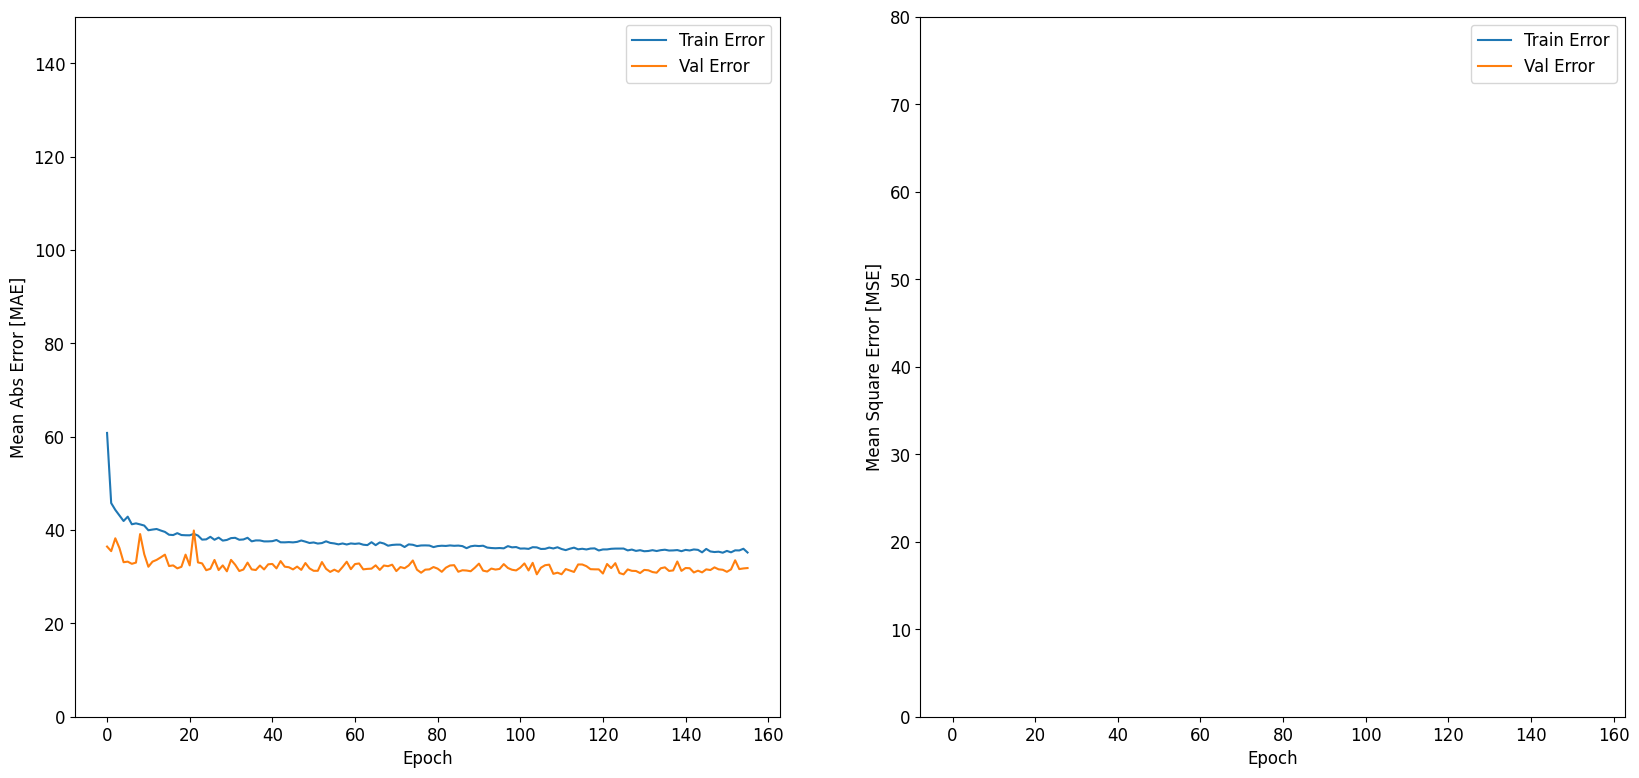

270/270 [==============================] - 0s 1ms/step - loss: 32.2469 - mae: 32.2469 - mse: 4454.3789
dangjin_floating test set의 MAE: 32.247


In [96]:
(model_dangjin, model_warehouse, model_floating, 
history_dangjin, history_warehouse, history_floating) = train(final_dataset_dangjin, final_dataset_ulsan, 'dangjin')

Epoch 1/200
216/216 - 1s - loss: 32.7030 - mae: 32.7030 - mse: 4348.2969 - val_loss: 22.1099 - val_mae: 22.1099 - val_mse: 1803.9849
Epoch 2/200
216/216 - 1s - loss: 25.0997 - mae: 25.0997 - mse: 2407.8782 - val_loss: 19.3980 - val_mae: 19.3980 - val_mse: 1378.2130
Epoch 3/200
216/216 - 0s - loss: 23.5214 - mae: 23.5214 - mse: 2113.8601 - val_loss: 20.2091 - val_mae: 20.2091 - val_mse: 1515.8544
Epoch 4/200
216/216 - 1s - loss: 23.5601 - mae: 23.5601 - mse: 2097.9644 - val_loss: 18.6156 - val_mae: 18.6156 - val_mse: 1378.3524
Epoch 5/200
216/216 - 1s - loss: 22.8136 - mae: 22.8136 - mse: 1989.9940 - val_loss: 18.9156 - val_mae: 18.9156 - val_mse: 1452.0845
Epoch 6/200
216/216 - 1s - loss: 22.8467 - mae: 22.8467 - mse: 2003.7324 - val_loss: 18.5493 - val_mae: 18.5493 - val_mse: 1325.9668
Epoch 7/200
216/216 - 1s - loss: 22.7513 - mae: 22.7513 - mse: 1993.4794 - val_loss: 18.4304 - val_mae: 18.4304 - val_mse: 1308.0911
Epoch 8/200
216/216 - 0s - loss: 22.5197 - mae: 22.5197 - mse: 1946.9

Epoch 63/200
216/216 - 0s - loss: 20.4592 - mae: 20.4592 - mse: 1662.2499 - val_loss: 17.6234 - val_mae: 17.6234 - val_mse: 1267.0552
Epoch 64/200
216/216 - 1s - loss: 20.3950 - mae: 20.3950 - mse: 1634.8542 - val_loss: 17.2626 - val_mae: 17.2626 - val_mse: 1204.9043
Epoch 65/200
216/216 - 0s - loss: 20.5028 - mae: 20.5028 - mse: 1667.0479 - val_loss: 17.6264 - val_mae: 17.6264 - val_mse: 1242.6256
Epoch 66/200
216/216 - 0s - loss: 20.4278 - mae: 20.4278 - mse: 1645.9357 - val_loss: 17.6384 - val_mae: 17.6384 - val_mse: 1230.3232
Epoch 67/200
216/216 - 1s - loss: 20.4848 - mae: 20.4848 - mse: 1667.8840 - val_loss: 18.7982 - val_mae: 18.7982 - val_mse: 1285.6415
Epoch 68/200
216/216 - 1s - loss: 20.5965 - mae: 20.5965 - mse: 1662.8986 - val_loss: 17.8735 - val_mae: 17.8735 - val_mse: 1226.9816
Epoch 69/200
216/216 - 0s - loss: 20.3093 - mae: 20.3093 - mse: 1638.4158 - val_loss: 17.7762 - val_mae: 17.7762 - val_mse: 1249.6515
Epoch 70/200
216/216 - 0s - loss: 20.6404 - mae: 20.6404 - mse

Epoch 124/200
216/216 - 1s - loss: 19.8643 - mae: 19.8643 - mse: 1585.9685 - val_loss: 17.3071 - val_mae: 17.3071 - val_mse: 1203.4379
Epoch 125/200
216/216 - 0s - loss: 19.6254 - mae: 19.6254 - mse: 1541.6725 - val_loss: 17.3811 - val_mae: 17.3811 - val_mse: 1251.7521
Epoch 126/200
216/216 - 0s - loss: 19.7143 - mae: 19.7143 - mse: 1531.4209 - val_loss: 17.4493 - val_mae: 17.4493 - val_mse: 1215.6355
Epoch 127/200
216/216 - 0s - loss: 19.7211 - mae: 19.7211 - mse: 1542.2738 - val_loss: 17.3533 - val_mae: 17.3533 - val_mse: 1199.5144
Epoch 128/200
216/216 - 0s - loss: 19.8220 - mae: 19.8220 - mse: 1566.6984 - val_loss: 17.9868 - val_mae: 17.9868 - val_mse: 1327.9979
Epoch 129/200
216/216 - 0s - loss: 19.7713 - mae: 19.7713 - mse: 1565.6625 - val_loss: 17.2296 - val_mae: 17.2296 - val_mse: 1227.5923
Epoch 130/200
216/216 - 0s - loss: 19.6529 - mae: 19.6529 - mse: 1548.1018 - val_loss: 17.3314 - val_mae: 17.3314 - val_mse: 1257.0225
Epoch 131/200
216/216 - 0s - loss: 19.7227 - mae: 19.72

Epoch 185/200
216/216 - 0s - loss: 19.2637 - mae: 19.2637 - mse: 1511.9275 - val_loss: 17.8142 - val_mae: 17.8142 - val_mse: 1226.8468
Epoch 186/200
216/216 - 0s - loss: 19.2554 - mae: 19.2554 - mse: 1493.1217 - val_loss: 17.0815 - val_mae: 17.0815 - val_mse: 1171.7069
Epoch 187/200
216/216 - 0s - loss: 19.2790 - mae: 19.2790 - mse: 1489.8331 - val_loss: 17.2715 - val_mae: 17.2715 - val_mse: 1174.6674
Epoch 188/200
216/216 - 0s - loss: 19.0982 - mae: 19.0982 - mse: 1464.0829 - val_loss: 17.2159 - val_mae: 17.2159 - val_mse: 1207.4799
Epoch 189/200
216/216 - 0s - loss: 19.2254 - mae: 19.2254 - mse: 1493.4965 - val_loss: 17.5776 - val_mae: 17.5776 - val_mse: 1262.9930
Epoch 190/200
216/216 - 0s - loss: 19.2260 - mae: 19.2260 - mse: 1476.1086 - val_loss: 17.0963 - val_mae: 17.0963 - val_mse: 1169.8514
Epoch 191/200
216/216 - 0s - loss: 19.2700 - mae: 19.2700 - mse: 1491.4227 - val_loss: 17.4708 - val_mae: 17.4708 - val_mse: 1215.6202
Epoch 192/200
216/216 - 0s - loss: 19.0827 - mae: 19.08

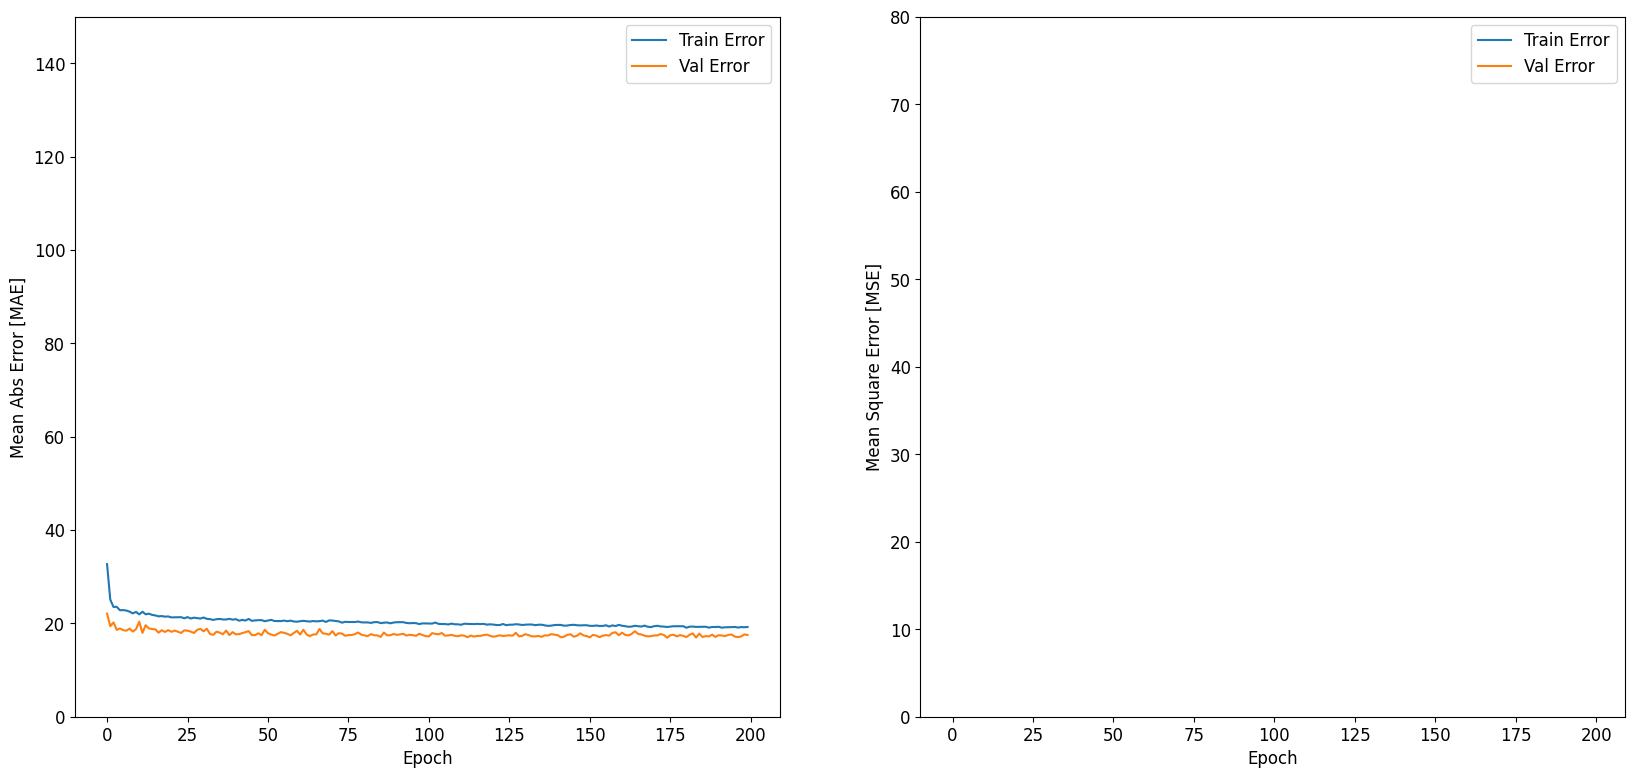

270/270 [==============================] - 0s 1ms/step - loss: 18.4375 - mae: 18.4375 - mse: 1348.5804
ulsan test set의 MAE: 18.438


In [97]:
model_ulsan, history_ulsan = train(final_dataset_dangjin, final_dataset_ulsan, 'ulsan')

# 3. 평가 및 제출

In [98]:
dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]

ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]

power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]

In [99]:
x_train, x_test, y_train, y_test = train_test_split(final_dataset_dangjin[dangjin_bound:dangjin_end][['cos(time)',
                                                                     'GHI',
                                                                     'Temperature',
                                                                     'Humidity',
                                                                     'Wind_x',
                                                                     'Wind_y']], 
                                                                final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_floating'],
                                                                test_size=0.2, shuffle=True)

In [100]:
x_train_ulsan, x_test_ulsan, y_train_ulsan, y_test_ulsan = train_test_split(
                    final_dataset_ulsan[ulsan_bound:ulsan_end][['cos(time)',
                                                                     'GHI',
                                                                     'Temperature',
                                                                     'Humidity',
                                                                     'Wind_x',
                                                                     'Wind_y']], 
                                                                final_dataset_ulsan[ulsan_bound:ulsan_end]['ulsan'],
                                                                test_size=0.2, shuffle=True)

In [101]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 3200
    target_idx = pd.DataFrame(sum_answer[sum_answer>=3200*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

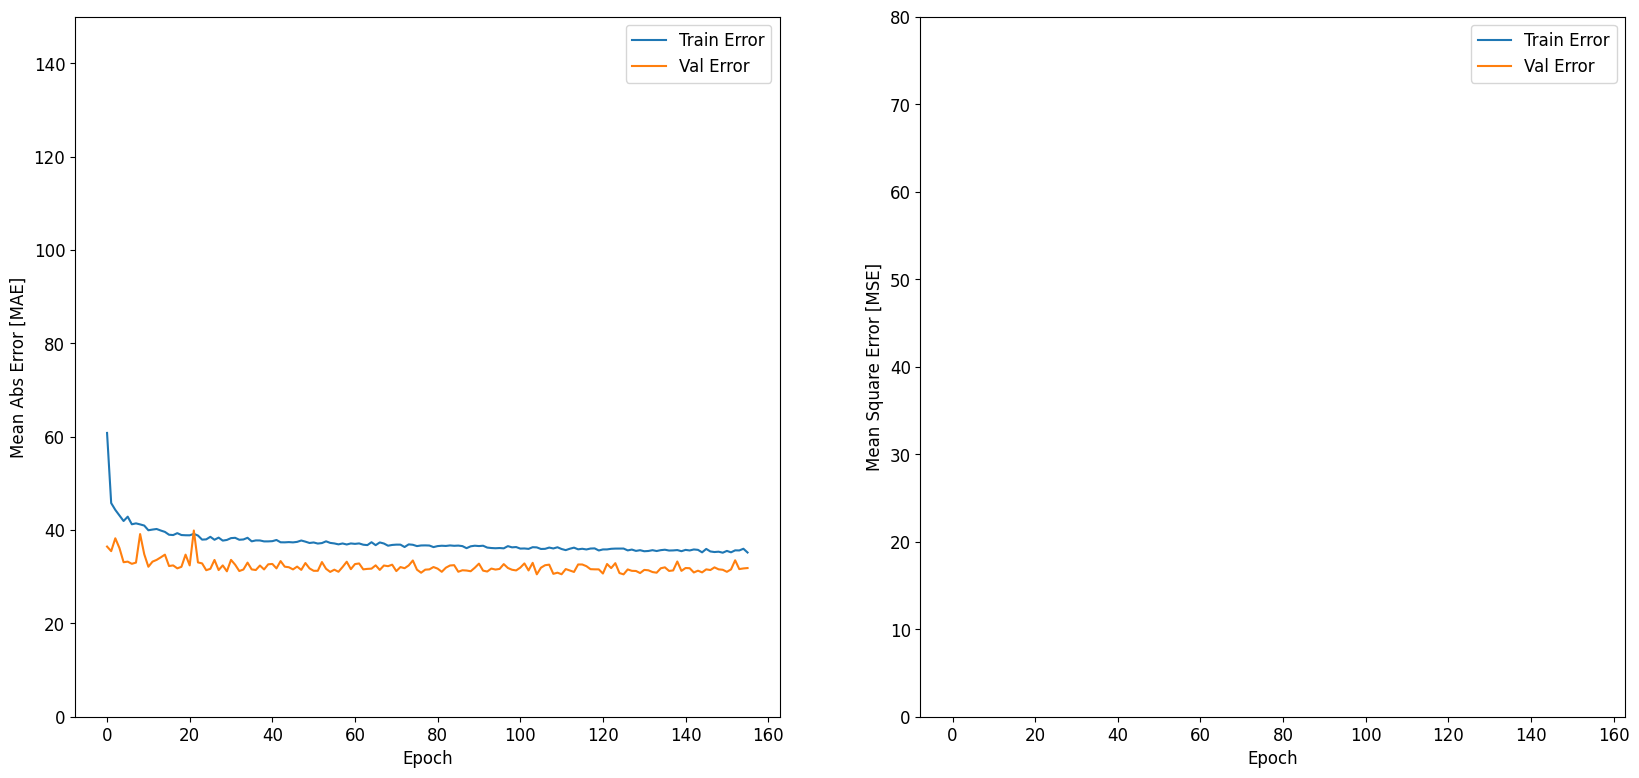

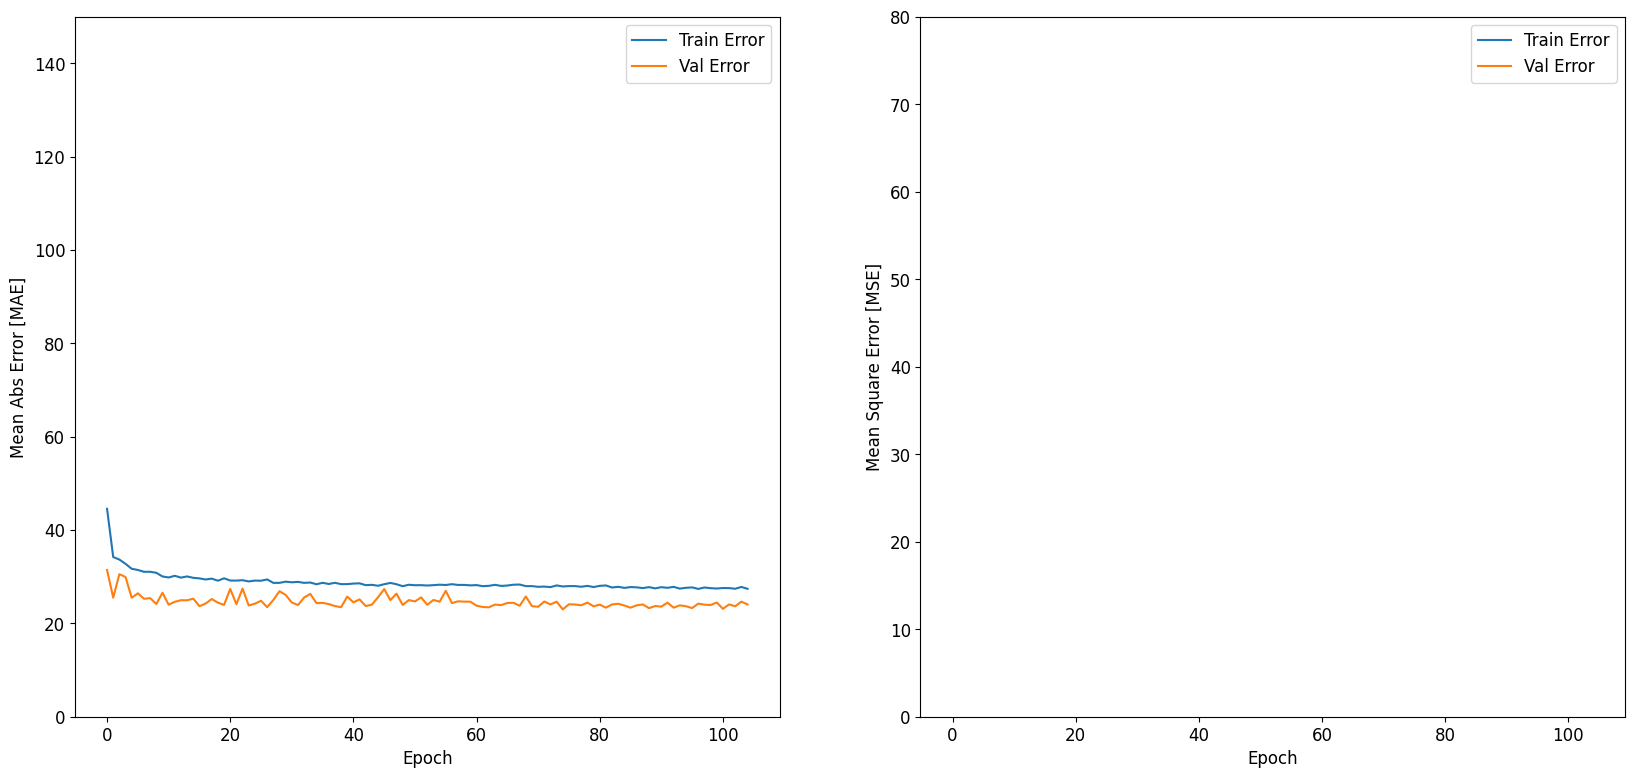

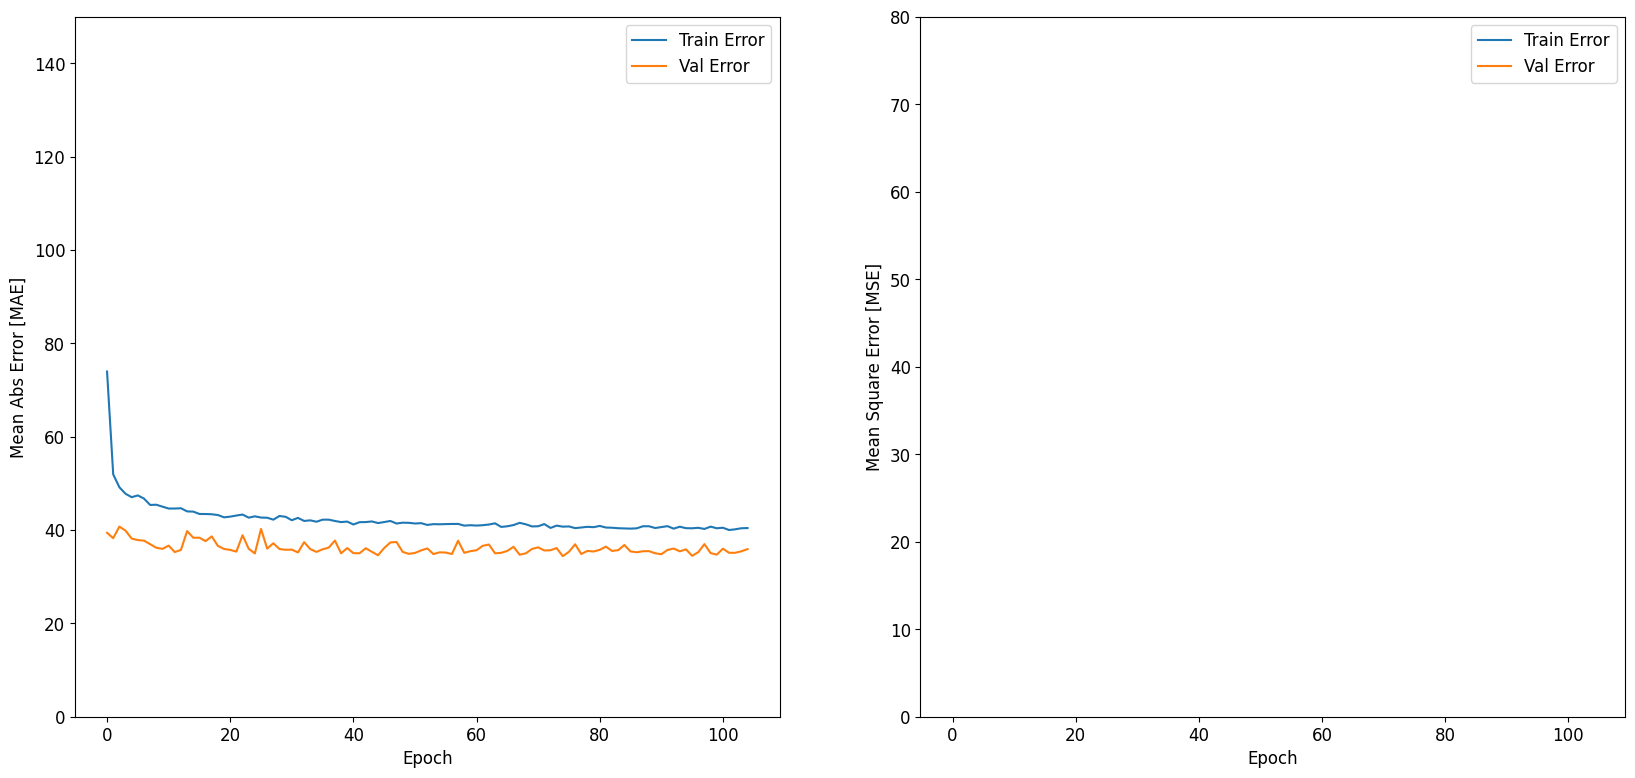

55/55 [==============================] - 0s 1ms/step - loss: 34.9618 - mae: 34.9618 - mse: 5658.4092
울산 제외 3개 장소 최종 submission 의 MAE: 34.962
NMAE for MLP : 2.4261136101066305


In [102]:
#=====================15~19 4개년 데이터로 20년 전체 예측============================#
plot_history(history_floating)
plot_history(history_warehouse)
plot_history(history_dangjin)
loss1, mae1, mse1 = model_floating.evaluate(x_test, y_test, verbose=1)
print("%s 의 MAE: %.3f"%('울산 제외 3개 장소 최종 submission',mae1))

answer_floating = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_floating']
answer_warehouse = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_warehouse']
answer_dangjin = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin']
answer_ulsan = final_dataset_ulsan[ulsan_bound:ulsan_end]['ulsan']

test_period = final_dataset_dangjin[dangjin_bound:dangjin_end][['cos(time)',
                                                                 'GHI',
                                                                 'Temperature',
                                                                 'Humidity',
                                                                 'Wind_x',
                                                                 'Wind_y']]

submission_floating = pd.DataFrame(np.squeeze(model_floating.predict(test_period)))
submission_warehouse = pd.DataFrame(np.squeeze(model_warehouse.predict(test_period)))
submission_dangjin = pd.DataFrame(np.squeeze(model_dangjin.predict(test_period)))
submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

answer_df = pd.concat([answer_dangjin, 
                       answer_warehouse, 
                       answer_floating,
                       answer_ulsan], axis=1).reset_index().drop('index', axis=1)
submission_df = pd.concat([submission_dangjin, 
                           submission_warehouse, 
                           submission_floating,
                           submission_ulsan], axis=1)
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

In [103]:
#========================== 15~19년 만 가지고1 21년 2월 예측 
#========================== 15~20년까지 포함하면 어떻게 될 지 모름
start = dangjin_end+31*24
end = dangjin_end+31*24+674
answer_floating = final_dataset_dangjin[start:end]['dangjin_floating']
answer_warehouse = final_dataset_dangjin[start:end]['dangjin_warehouse']
answer_dangjin = final_dataset_dangjin[start:end]['dangjin']
answer_ulsan = final_dataset_ulsan[start:end]['ulsan']

test_period = final_dataset_dangjin[start:end][['cos(time)',
                                                 'GHI',
                                                 'Temperature',
                                                 'Humidity',
                                                 'Wind_x',
                                                 'Wind_y']]

submission_floating = pd.DataFrame(np.squeeze(model_floating.predict(test_period)))
submission_warehouse = pd.DataFrame(np.squeeze(model_warehouse.predict(test_period)))
submission_dangjin = pd.DataFrame(np.squeeze(model_dangjin.predict(test_period)))
submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

answer_df = pd.concat([answer_dangjin, 
                       answer_warehouse, 
                       answer_floating,
                       answer_ulsan], axis=1).reset_index().drop('index', axis=1)
submission_df = pd.concat([submission_dangjin, 
                           submission_warehouse, 
                           submission_floating,
                           submission_ulsan], axis=1)
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

NMAE for MLP : 2.025369050741381


* submission file 생성

In [120]:
s = np.where(raw_weather_dangjin['Time'] == '2021-02-01 0:00')[0][0]
e = np.where(raw_weather_dangjin['Time'] == '2021-03-01 0:00')[0][0]

time_axis = raw_weather_dangjin['Time'][s:e].reset_index().drop('index', axis=1)

In [121]:
sample_submission = pd.read_csv('Solar_Power_mycode/dacon_data/sample_submission.csv')

In [122]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 0:00,0.000001,0.000145,0.000397,0.000004
1,2021-02-01 1:00,0.000001,0.000145,0.000397,0.000004
2,2021-02-01 2:00,0.000001,0.000145,0.000397,0.000004
3,2021-02-01 3:00,0.000001,0.000145,0.000397,0.000004
4,2021-02-01 4:00,0.000001,0.000145,0.000397,0.000004
...,...,...,...,...,...
667,2021-02-28 19:00,0.000001,0.000145,0.000397,0.000004
668,2021-02-28 20:00,0.000001,0.000145,0.000397,0.000004
669,2021-02-28 21:00,0.000001,0.000145,0.000397,0.000004
670,2021-02-28 22:00,0.000001,0.000145,0.000397,0.000004


In [123]:
new_submission = pd.concat([time_axis, submission_df],axis=1)
submission = new_submission[:672]
submission.columns = ['time', 'dangjin_floating', 'dangjin_warehouse','dangjin',"ulsan"]
temp_submission = pd.concat([sample_submission['time'],submission.drop('time', axis=1)], axis=1)

In [124]:
final_submission = pd.concat([temp_submission[:672], sample_submission[672:]], axis=0)

In [125]:
final_submission.to_csv('210528_YJ_submission2.csv', header=True, index=False)
final_submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.000001,0.000145,0.000397,0.000004
1,2021-02-01 02:00:00,0.000001,0.000145,0.000397,0.000004
2,2021-02-01 03:00:00,0.000001,0.000145,0.000397,0.000004
3,2021-02-01 04:00:00,0.000001,0.000145,0.000397,0.000004
4,2021-02-01 05:00:00,0.000001,0.000145,0.000397,0.000004
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


## 부록. 머신러닝 기법 + 시각화 파트
* 여기도 코드 업데이트가 필요함

In [39]:
#=========SVM 회귀==========#
from sklearn.svm import SVR

#GHI_svm_reg = SVR(kernel = 'rbf',degree=3, C=1000, epsilon = 0.01, verbose = True)
#GHI_svm_reg.fit(x_train_dangjin, y_train_dangjin)

In [65]:
#=========XGBoost 회귀==========#
import xgboost
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
import lightgbm
from lightgbm import LGBMRegressor
lgbm_reg = LGBMRegressor(boosting_type='gbdt',
                            num_leaves = 256,
                            max_depth = 9,
                            learning_rate = 0.05,
                            n_estimators=100)
lgbm_reg.fit(x_train, y_train)

LGBMRegressor(learning_rate=0.05, max_depth=9, num_leaves=256)

In [61]:
def Evaluate_NMAE_dangjin(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 1000
    target_idx = pd.DataFrame(sum_answer[sum_answer>=1000*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [69]:
XGB_submission_df = xgb_reg.predict(test_period)
LGB_submission_df = lgbm_reg.predict(test_period)

In [94]:
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(submission_dangjin)))

#print("NMAE for ULS :",Evaluate_NMAE(answer_ulsan, MLP_submission_ulsan))
print("NMAE for LGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
#print("NMAE for SVM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(SVM_submission_df)))
print("NMAE for XGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))

NMAE for MLP : 0.8324839760274106
NMAE for LGB : 1.0809269618061057
NMAE for XGB : 1.0975255660201197


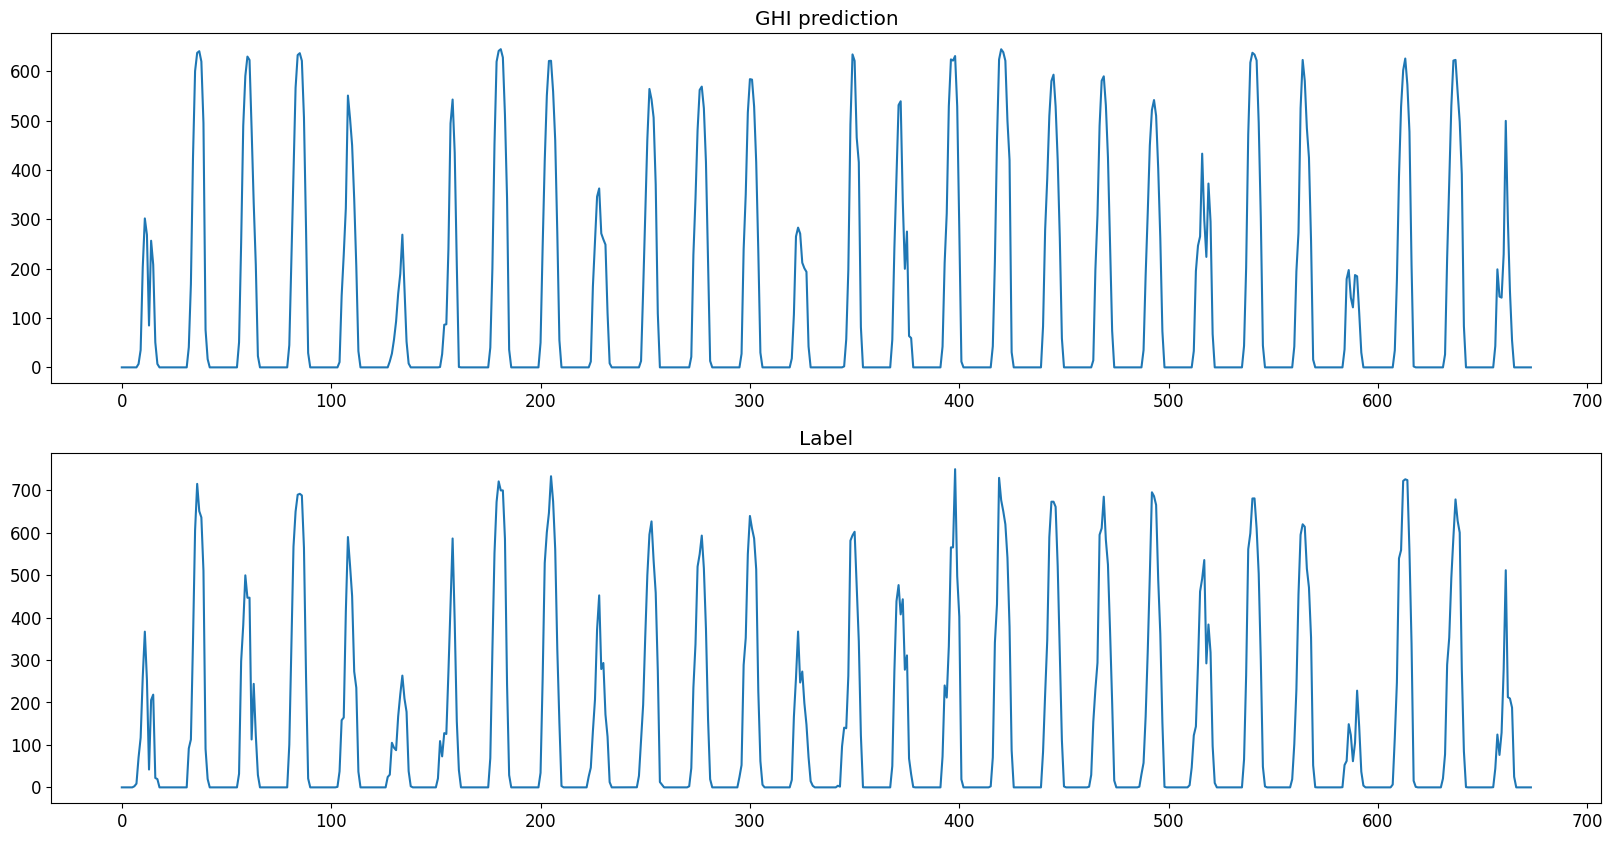

In [104]:
length = 25632-24888
fig = plt.figure(figsize=(20,10))
plt.rc('font', size = 12)
plt.subplot(211)
plt.title('GHI prediction')
plt.plot(range(0,len(test_period['cos(time)'][-length:])), 
         np.squeeze(model_dangjin.predict(test_period))[-length:])

plt.subplot(212)
plt.title('Label')
plt.plot(range(0,len(test_period['cos(time)'][-length:])), 
         answer_df['dangjin'][-length:])

In [215]:
year = 24*365

In [223]:
np.where(answer_floating>)

(array([], dtype=int64),)

In [226]:
reset

,index,dangjin_floating
0,54768,0.0
1,54769,0.0
2,54770,0.0
3,54771,0.0
4,54772,0.0
...,...,...
715,55483,0.0
716,55484,0.0
717,55485,0.0
718,55486,0.0


,cos(time),GHI,Temperature,Humidity,Wind_x,Wind_y
53352,1.000000,0.0,0.431373,0.820225,0.575864,0.571761
53353,0.982963,0.0,0.438503,0.820225,0.534215,0.564148
53354,0.933013,0.0,0.465241,0.853933,0.529676,0.513447
53355,0.853553,0.0,0.468806,0.943820,0.539133,0.519487
53356,0.750000,0.0,0.470588,0.977528,0.544195,0.461390
...,...,...,...,...,...,...
54021,0.853553,0.0,0.483066,0.393258,0.619520,0.570826
54022,0.933013,0.0,0.475936,0.494382,0.567419,0.589420
54023,0.982963,0.0,0.493761,0.382022,0.627024,0.560934
54024,1.000000,0.0,0.488414,0.449438,0.566581,0.567681


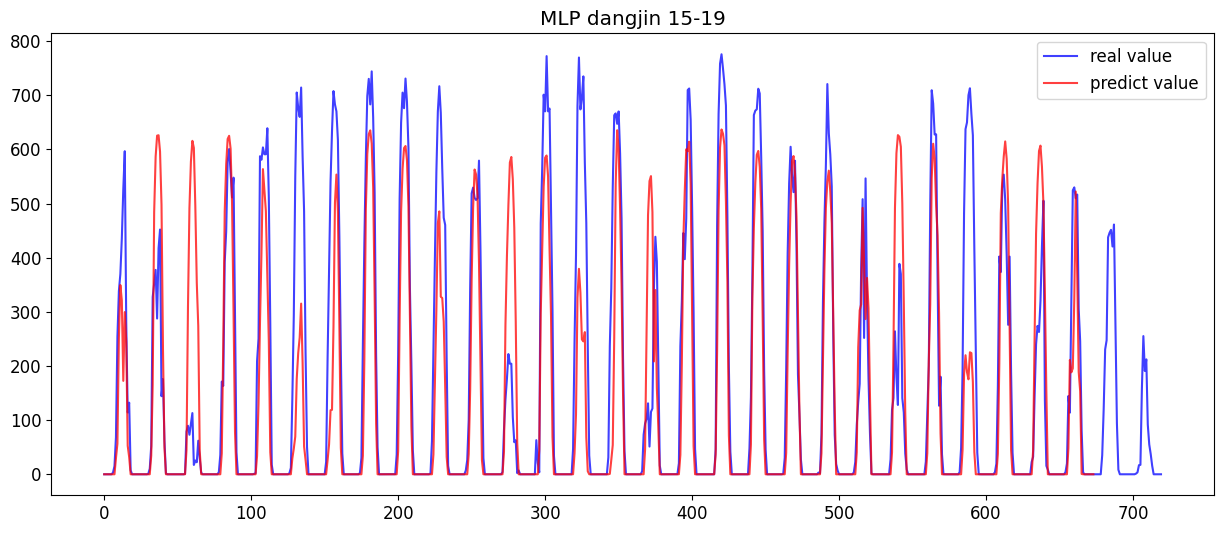

In [92]:
place = ['dangjin','dangjin_warehouse','dangjin_floating']
place_idx = 0
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin[place[place_idx]][-24*30:].reset_index()
chart.plot(reset[place[place_idx]], marker='', color='blue', alpha = 0.75, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(test_period))[-24*30:], marker='', color='red', alpha = 0.75, label='predict value')
chart.set_title('MLP {} 15-19'.format(place[place_idx]))
plt.legend(loc = 'best') 

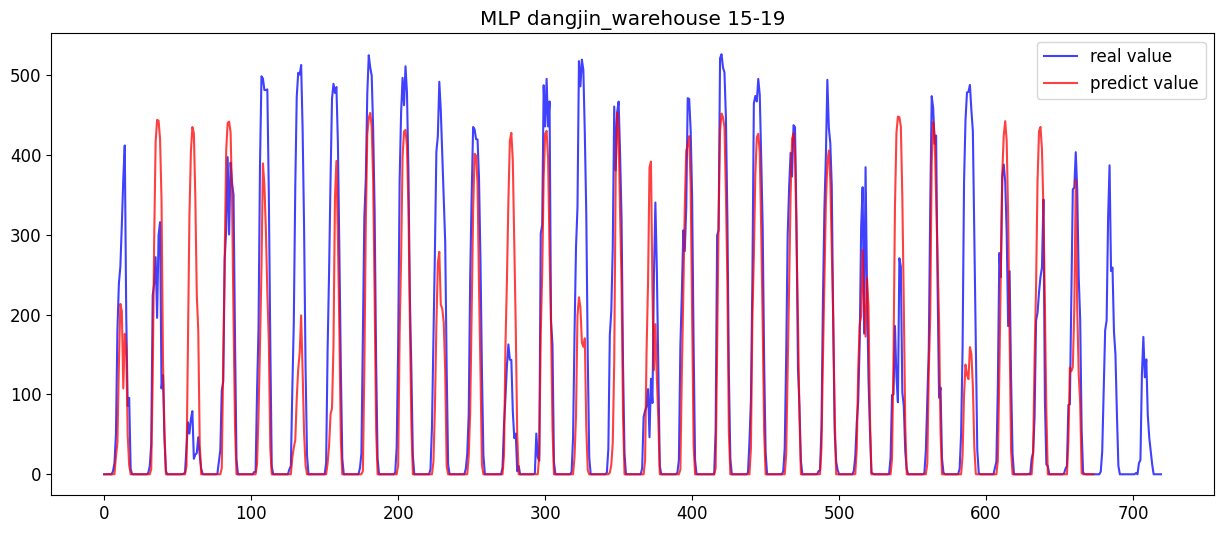

In [91]:
place = ['dangjin','dangjin_warehouse','dangjin_floating']
place_idx = 1
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin[place[place_idx]][-24*30:].reset_index()
chart.plot(reset[place[place_idx]], marker='', color='blue', alpha = 0.75, label='real value')
chart.plot(np.squeeze(model_warehouse.predict(test_period))[-24*30:], marker='', color='red', alpha = 0.75, label='predict value')
chart.set_title('MLP {} 15-19'.format(place[place_idx]))
plt.legend(loc = 'best') 

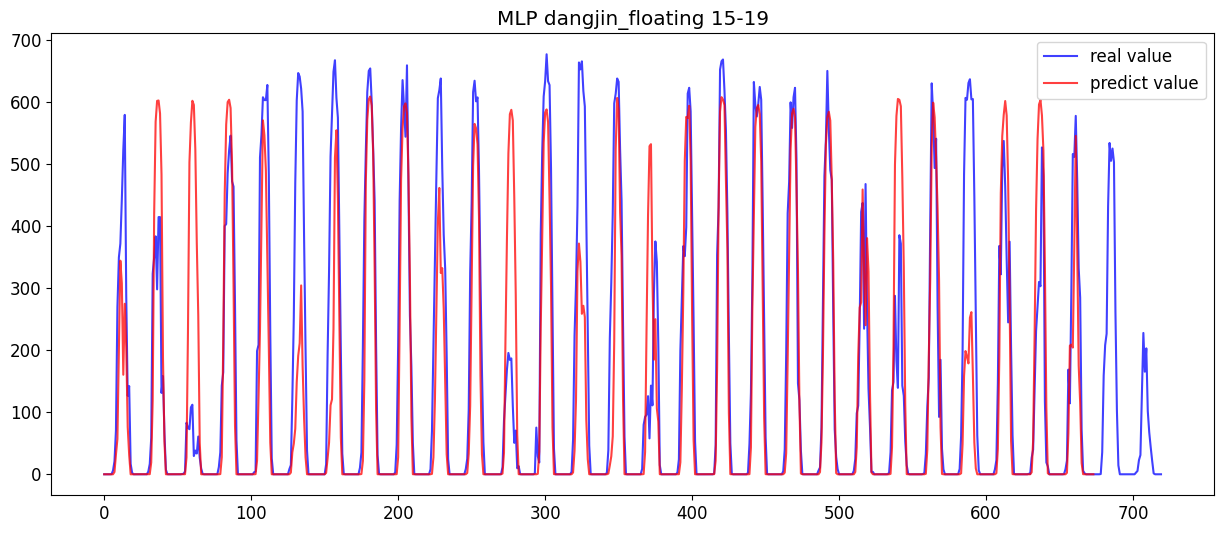

In [90]:
place = ['dangjin','dangjin_warehouse','dangjin_floating']
place_idx = 2
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin[place[place_idx]][-24*30:].reset_index()
chart.plot(reset[place[place_idx]], marker='', color='blue', alpha = 0.75, label='real value')
chart.plot(np.squeeze(model_floating.predict(test_period))[-24*30:], marker='', color='red', alpha = 0.75, label='predict value')
chart.set_title('MLP {} 15-19'.format(place[place_idx]))
plt.legend(loc = 'best') 

NMAE for LGBM : 5.8487756257097585


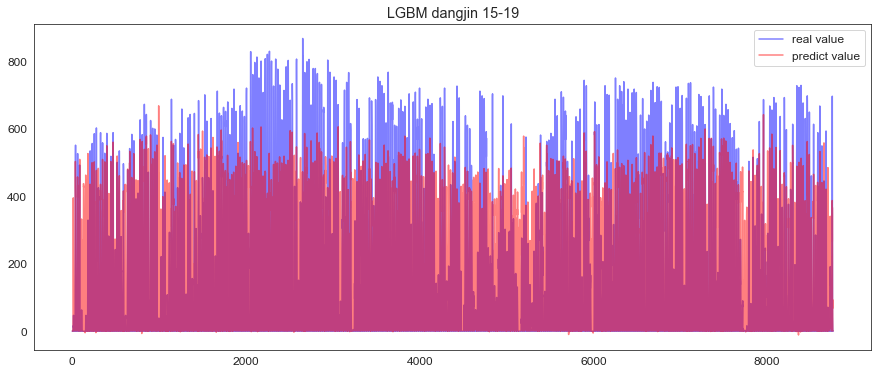

In [232]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for LGBM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.50,
                                                                   label='predict value')
chart.set_title('LGBM dangjin 15-19')
plt.legend(loc = 'best');

NMAE for XGBoost : 6.480300503433263


C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


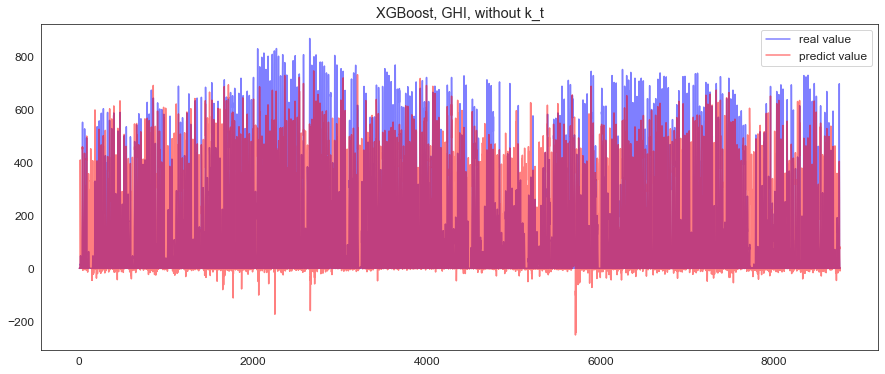

In [227]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for XGBoost :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('XGBoost, GHI, without k_t')
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(211)
sns.lineplot(data=data_dangjin, x= data_dangjin.index, y = 'Power', linewidth = 0.2)

In [289]:
reset['Power']

0      0
1      0
2      0
3      0
4      0
      ..
739    0
740    0
741    0
742    0
743    0
Name: Power, Length: 744, dtype: int64